## By Dilleswari

In [1]:
import torch 
from src.models import Join_fusion
from torchinfo import summary
import pandas as pd
import numpy as np
import librosa
import sys
sys.path.append("./src")
import utils

Loading Checkpoint


In [ ]:
model_config = {
                "inputdim" : 64,
                "outputdim" : 2
                }

model = Join_fusion(model_config, model_config['inputdim'], model_config["outputdim"])

ckp_path = "./experiments/Join_fusion/2025-07-09_19-54-07_6ab942ac5cd011f08f033cecefb1a652/run_model_9_loss=-0.2484.pt"
ckp = torch.load(ckp_path, map_location='cpu')

try:
    model.load_state_dict(ckp)
    print("Successfully loaded model weights")
except:
    print("Unsuccessful in loading model weights")

model.eval()
#summary(model, input_size= [(1,501,64), (1,1001,104)], col_names = ["input_size","output_size","num_params"], device='cpu')
                            # mixture   reference

Successfully loaded model weights


Join_fusion(
  (detection): CDur_fusion(
    (gru): GRU(768, 768, batch_first=True, bidirectional=True)
    (fusion): Fusion(
      (fuse_layer1): conv1d(
        (conv): Conv1d(768, 3072, kernel_size=(1,), stride=(1,))
        (act): ReLU()
      )
      (fuse_layer2): conv1d(
        (conv): Conv1d(768, 3072, kernel_size=(1,), stride=(1,))
        (act): ReLU()
      )
      (avg_pool): AvgPool1d(kernel_size=(4,), stride=(4,), padding=(0,))
    )
    (fc): Linear(in_features=1536, out_features=1536, bias=True)
    (outputlayer): Linear(in_features=1536, out_features=2, bias=True)
  )
  (AudioEncoder): ConvNeXt(
    (spectrogram_extractor): Spectrogram(
      (stft): STFT(
        (conv_real): Conv1d(1, 513, kernel_size=(1024,), stride=(320,), bias=False)
        (conv_imag): Conv1d(1, 513, kernel_size=(1024,), stride=(320,), bias=False)
      )
    )
    (logmel_extractor): LogmelFilterBank()
    (spec_augmenter): SpecAugmentation(
      (time_dropper): DropStripes()
      (freq_drop

In [3]:
import pandas as pd
tsv_file = "./data/flists/urban_sed_test_strong_modified.tsv"
df = pd.read_csv(tsv_file, sep='\t')
df

,filename,onset,offset,event_label
0,/home/ananth/datasets/URBAN-SED/audio/test/sou...,4.516348,7.253393,jackhammer
1,/home/ananth/datasets/URBAN-SED/audio/test/sou...,5.106336,7.081667,engine_idling
2,/home/ananth/datasets/URBAN-SED/audio/test/sou...,5.813735,7.963874,engine_idling
3,/home/ananth/datasets/URBAN-SED/audio/test/sou...,6.353976,7.430690,dog_bark
4,/home/ananth/datasets/URBAN-SED/audio/test/sou...,8.037359,9.902325,drilling
...,...,...,...,...
9951,/home/ananth/datasets/URBAN-SED/audio/test/sou...,7.794474,10.000000,gun_shot
9952,/home/ananth/datasets/URBAN-SED/audio/test/sou...,0.016581,3.391536,dog_bark
9953,/home/ananth/datasets/URBAN-SED/audio/test/sou...,1.222317,2.517615,car_horn
9954,/home/ananth/datasets/URBAN-SED/audio/test/sou...,5.517929,6.631534,gun_shot


In [ ]:
import pandas as pd
tsv_file = "./data/flists/urban_sed_test_strong_modified.tsv"
df = pd.read_csv(tsv_file, sep='\t')
df

,filename,onset,offset,event_label
0,/home/ananth/datasets/URBAN-SED/audio/test/sou...,4.516348,7.253393,jackhammer
1,/home/ananth/datasets/URBAN-SED/audio/test/sou...,5.106336,7.081667,engine_idling
2,/home/ananth/datasets/URBAN-SED/audio/test/sou...,5.813735,7.963874,engine_idling
3,/home/ananth/datasets/URBAN-SED/audio/test/sou...,6.353976,7.430690,dog_bark
4,/home/ananth/datasets/URBAN-SED/audio/test/sou...,8.037359,9.902325,drilling
...,...,...,...,...
9951,/home/ananth/datasets/URBAN-SED/audio/test/sou...,7.794474,10.000000,gun_shot
9952,/home/ananth/datasets/URBAN-SED/audio/test/sou...,0.016581,3.391536,dog_bark
9953,/home/ananth/datasets/URBAN-SED/audio/test/sou...,1.222317,2.517615,car_horn
9954,/home/ananth/datasets/URBAN-SED/audio/test/sou...,5.517929,6.631534,gun_shot


In [ ]:
reference_list = []

for _, row in df.iterrows():
    filename, onset, offset, event_label= row['filename'], row['onset'], row['offset'], row['event_label']
    filename = filename.replace("./datasets/URBAN-SED/audio/test/","")

    reference_entry = {
                            'event_label': event_label,
                            'event_onset': onset,
                            'event_offset': offset,
                            'file': filename
                        }
    reference_list.append(reference_entry)

## Create predicted output
### Here we are using the predictions from default threshold which is set to 0.37. Later on, in this notebook we will find the optimum threshold and the performance
### Change the file_path in the below cell to load the predictions

In [ ]:
estimated_list = []

#file_path = "./experiments/Join_fusion/2024-08-10_17-15-08_03c282e8570e11efaca83cecefb1a652/hard_predictions_urban_sed_test_strong_threshold_0.37.txt"
#file_path = "./experiments/Join_fusion/2025-06-30_14-36-06_876fba98559111f0a5da3cecefb1a652/hard_predictions_urban_sed_test_strong_threshold_0.37.txt"
file_path = "./experiments/Join_fusion/2025-07-09_19-54-07_6ab942ac5cd011f08f033cecefb1a652/hard_predictions_urban_sed_test_strong_threshold_0.37.txt"
with open(file_path, 'r') as file:
    lines = file.readlines()
    lines = lines[1:]

for line in lines:
    out = line.strip().split('\t')

    filename = out[0]
    onset = float(out[1])
    offset = float(out[2])
    event_label = out[3]

    estimated_entry = {
                            'event_label': event_label,
                            'event_onset': onset,
                            'event_offset': offset,
                            'file': filename
                         }
    estimated_list.append(estimated_entry)

In [6]:
import sed_eval
import dcase_util
from tqdm import tqdm

reference_event_list = dcase_util.containers.MetaDataContainer(reference_list)
estimated_event_list = dcase_util.containers.MetaDataContainer(estimated_list)

# segment based metrics, change segment length by modifying time_resolution(in sec)
segment_based_metrics = sed_eval.sound_event.SegmentBasedMetrics(
    event_label_list=reference_event_list.unique_event_labels,
    time_resolution=1.0
)

for filename in tqdm(reference_event_list.unique_files):
    
    reference_event_list_for_current_file = reference_event_list.filter(filename=filename)
    estimated_event_list_for_current_file = estimated_event_list.filter(filename=filename)

    segment_based_metrics.evaluate(
        reference_event_list=reference_event_list_for_current_file,
        estimated_event_list=estimated_event_list_for_current_file
    )

# print report
print(segment_based_metrics)



100%|██████████| 2000/2000 [00:51<00:00, 38.48it/s]

Segment based metrics
  Evaluated length                  : 18147.42 sec
  Evaluated files                   : 2000 
  Segment length                    : 1.00 sec

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 83.62 %
    Precision                       : 80.77 %
    Recall                          : 86.68 %
  Error rate
    Error rate (ER)                 : 0.30 
    Substitution rate               : 0.04 
    Deletion rate                   : 0.09 
    Insertion rate                  : 0.17 
  Accuracy
    Sensitivity                     : 86.68 %
    Specificity                     : 96.59 %
    Balanced accuracy               : 91.64 %
    Accuracy                        : 95.19 %

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 83.55 %
    Precision                       : 81.10 %
    Recall                          : 86.39 %
  Error rate
    Error rate (ER)                 : 0.34 
    Deletion r

In [ ]:
# Save segment-based metrics report to a file
output_path = "./experiments/Join_fusion/2025-07-09_19-54-07_6ab942ac5cd011f08f033cecefb1a652/segment_based_results.txt"

with open(output_path, "w") as f:
    f.write(str(segment_based_metrics))

print(f"Segment-based metrics saved to: {output_path}")


Segment-based metrics saved to: /home/ananth/adarsh_Targeted_Audio_Search/experiments/Join_fusion/2025-07-09_19-54-07_6ab942ac5cd011f08f033cecefb1a652/segment_based_results.txt


## Finding the optimum threshold
### Evaluating the model to find the best threshold on the test set

In [11]:
import sys
sys.path.append('./src/')
import numpy as np
import torch
import os
from pathlib import Path
from src import dataset, models
from tqdm import tqdm
import pandas as pd
#from ignite.utils import convert_tensor
from ignite.engine import convert_tensor
import torch
from src import utils
import glob


DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"   

def forward(model, batch):
    inputs, frame_level_targets, time, embedding,embed_label, filenames,events = batch
    inputs = convert_tensor(inputs, device=DEVICE, non_blocking=True)
    frame_level_targets = convert_tensor(frame_level_targets.float(), device=DEVICE, non_blocking=True)
    embedding = convert_tensor(embedding, device=DEVICE, non_blocking=True)
    embed_label = convert_tensor(embed_label,device=DEVICE,non_blocking=True)
    decision,decision_up,logit = model(inputs,embedding)
    return decision,decision_up, frame_level_targets, time,embed_label,logit


def evaluate(
            experiment_path: str,
            time_ratio=10. / 1000,
            postprocessing='median',
            threshold=None,
            window_size=None,
            **kwargs):
    
  
    config = torch.load(list(Path(f'{experiment_path}').glob("run_config*"))[0], map_location='cpu')
    config_parameters = dict(config, **kwargs)

    model_parameters = torch.load(glob.glob("{}/run_model*".format(experiment_path))[0],
                                    map_location=lambda storage, loc: storage)   
    strong_labels_df = pd.read_csv(config_parameters['label'], sep='\t')

    if not np.issubdtype(strong_labels_df['filename'].dtype, np.number):
        strong_labels_df['filename'] = strong_labels_df['filename'].apply(os.path.basename)
    if 'audiofilepath' in strong_labels_df.columns:  
        strong_labels_df['audiofilepath'] = strong_labels_df['audiofilepath'].apply(os.path.basename)
        colname = 'audiofilepath'  # AVE
    else:
        colname = 'filename'  # Dcase etc.
    
    if "event_labels" in strong_labels_df.columns:
        assert False, "Data with the column event_labels are used to train not to evaluate"
    
    # Create Test Dataloader
    dataloader = dataset.getdataloader_join(
        config_parameters['test_data'],
        config_parameters['spk_emb_file_path'],
        batch_size=1, shuffle=False)
    
    # Load the model
    model = getattr(models, config_parameters['model'])(
        model_config=config_parameters,inputdim=64, outputdim=2, **config_parameters['model_args'])
    
    try:
        model.load_state_dict(model_parameters)
        print("Successfully loaded model")
    except:
        print("Unsuccessful in loading model")
        sys.exit(1)

    model = model.to(DEVICE).eval()

    thresholds = np.arange(0.31, 0.51, 0.01)
    if window_size is None:
        window_size = 1
    print("Postprocessing: ", postprocessing)
    print("Window Size: ", window_size)

    # In One pass generate all the predictions and save it
    predictions_list = [] # to save model predictions
    with torch.no_grad():
        for batch in tqdm(dataloader, unit='file', leave=False): 
            inputs, frame_level_target, time, embedding,embed_label, filenames,events = batch
            decision,decision_up, frame_level_target, time,embed_label,logit = forward(model, batch) 
            
            pred = decision_up.detach().cpu().numpy()
            pred = pred[:,:,0]
            
            predictions_list.append(pred)
        print("Evaluation dataset :", len(predictions_list), "files")
    
    # Saving all the predictions for each threshold inside threshold_wise_output folder
    folder_name = "threshold_wise_outputs"
    folder_path = os.path.join(experiment_path, folder_name)
    
    if not os.path.exists(folder_path):
        os.makedirs(folder_path, exist_ok=True)
    

    # Now get performance over all the thresholds and save the f-score, accuracy for each threshold
    for thres in thresholds:
        
        print("Threshold: ", round(thres,2))
        time_predictions = [] # for every threshold we need time predictions of all files which will be stored in this list

        for idx, batch in tqdm(enumerate(dataloader), unit='file', leave=False): 
            inputs, frame_level_target, time, embedding,embed_label, filenames,events = batch
            pred = predictions_list[idx]
            filtered_pred = utils.median_filter(pred, window_size=window_size, threshold=thres)
            
            decoded_pred = []
            decoded_pred_ = utils.decode_with_timestamps(events[0],filtered_pred[0,:])
            if len(decoded_pred_) == 0: # neg deal
                decoded_pred_.append((events[0],0,0))
            decoded_pred.append(decoded_pred_)

            for num_batch in range(len(decoded_pred)): # when we test our model,the batch_size is 1
            
                filename = filenames[num_batch]
                label_prediction = decoded_pred[num_batch]
                for event_label, onset, offset in label_prediction:
                    time_predictions.append({
                        'filename': filename,
                        'onset': onset,
                        'offset': offset,
                        'event_label': event_label})
        
        assert len(time_predictions) > 0, "No outputs, lower threshold?"

        pred_df = pd.DataFrame(time_predictions, columns=['filename', 'onset', 'offset','event_label']) 
        pred_df = utils.predictions_to_time(pred_df, ratio=time_ratio) 
            
        pred_csv_path = os.path.join(folder_path, "predictions_threshold_{}.txt".format(round(thres,2)))
        pred_df.to_csv(pred_csv_path, index=False, sep="\t")
    

In [ ]:
# Call the above evaluate function
experiment_path = "./experiments/Join_fusion/2025-06-30_14-36-06_876fba98559111f0a5da3cecefb1a652" 
time_ratio = 10.0/1000

config_file = "./runconfigs/target_sed_join_train.yaml"
config_parameters = utils.parse_config_or_kwargs(config_file)

postprocessing = config_parameters.get('postprocessing', 'double')  
window_size = config_parameters.get('window_size', None)

evaluate(experiment_path,
            time_ratio=time_ratio,
            postprocessing=postprocessing,
            window_size=window_size)

get spk_id_dict and spk_emb_dict
Successfully loaded model
Postprocessing:  median
Window Size:  1


Evaluation dataset : 7702 files
Threshold:  0.31


Threshold:  0.32


KeyboardInterrupt: 

### The predictions gets saved in the folder named as threshold_wise_outputs for each threshold, and now compare the performance of each threshold with the ground truth by recording F-score and accuracy

#### Load all the thresholded predicition files and evaluate them

In [10]:
import os
threshold_folder_path = os.path.join(experiment_path, "threshold_wise_outputs")
files = sorted(os.listdir(threshold_folder_path))
print(files)

['predictions_threshold_0.1.txt', 'predictions_threshold_0.11.txt', 'predictions_threshold_0.12.txt', 'predictions_threshold_0.13.txt', 'predictions_threshold_0.14.txt', 'predictions_threshold_0.15.txt', 'predictions_threshold_0.16.txt', 'predictions_threshold_0.17.txt', 'predictions_threshold_0.18.txt', 'predictions_threshold_0.19.txt', 'predictions_threshold_0.2.txt', 'predictions_threshold_0.21.txt', 'predictions_threshold_0.22.txt', 'predictions_threshold_0.23.txt', 'predictions_threshold_0.24.txt', 'predictions_threshold_0.25.txt', 'predictions_threshold_0.26.txt', 'predictions_threshold_0.27.txt', 'predictions_threshold_0.28.txt', 'predictions_threshold_0.29.txt', 'predictions_threshold_0.3.txt', 'predictions_threshold_0.31.txt', 'predictions_threshold_0.32.txt', 'predictions_threshold_0.33.txt', 'predictions_threshold_0.34.txt', 'predictions_threshold_0.35.txt', 'predictions_threshold_0.36.txt', 'predictions_threshold_0.37.txt', 'predictions_threshold_0.38.txt', 'predictions_thr

### Create reference output

In [11]:
import pandas as pd
import sed_eval
import dcase_util
from tqdm import tqdm


tsv_file = "./data/flists/urban_sed_test_strong_modified.tsv"
df = pd.read_csv(tsv_file, sep='\t')

reference_list = []

for _, row in df.iterrows():
    filename, onset, offset, event_label= row['filename'], row['onset'], row['offset'], row['event_label']
    filename = filename.replace("/home/ananth/datasets/URBAN-SED/audio/test/","")

    reference_entry = {
                            'event_label': event_label,
                            'event_onset': onset,
                            'event_offset': offset,
                            'file': filename
                         }
    reference_list.append(reference_entry)

### Compute the metrics and save it in csv file

In [12]:
f_measure_list = []
accuracy_list = []
precision_list = []
recall_list = []
threshold_list = []


for file in tqdm(files):
    
    if file == ".ipynb_checkpoints": # remove .pynb_checkpoints file
        continue

    threshold = round(float(file.split("_")[-1].replace(".txt","")),2)
    
    file_path = os.path.join(threshold_folder_path, file)
    
    with open(file_path, 'r') as file:
        lines = file.readlines()
        lines = lines[1:]

    estimated_list = []

    for line in lines:
        out = line.strip().split('\t')

        filename = out[0]
        onset = float(out[1])
        offset = float(out[2])
        event_label = out[3]

        estimated_entry = {
                                'event_label': event_label,
                                'event_onset': onset,
                                'event_offset': offset,
                                'file': filename
                            }
        estimated_list.append(estimated_entry)

    reference_event_list = dcase_util.containers.MetaDataContainer(reference_list)
    estimated_event_list = dcase_util.containers.MetaDataContainer(estimated_list)

    segment_based_metrics = sed_eval.sound_event.SegmentBasedMetrics(
        event_label_list=reference_event_list.unique_event_labels,
        time_resolution=1.0
    )

    for filename in reference_event_list.unique_files:
        
        reference_event_list_for_current_file = reference_event_list.filter(filename=filename)
        estimated_event_list_for_current_file = estimated_event_list.filter(filename=filename)

        segment_based_metrics.evaluate(
            reference_event_list=reference_event_list_for_current_file,
            estimated_event_list=estimated_event_list_for_current_file
        )

    threshold_list.append(threshold)
    f_measure_list.append(segment_based_metrics.overall_f_measure()['f_measure'])
    precision_list.append(segment_based_metrics.overall_f_measure()['precision'])
    recall_list.append(segment_based_metrics.overall_f_measure()['recall'])
    accuracy_list.append(segment_based_metrics.overall_accuracy()['accuracy'])

df = pd.DataFrame({
                    "Threshold" : threshold_list, 
                    "F-score" : f_measure_list, 
                    "Precision" : precision_list, 
                    "Recall" : recall_list, 
                    "Accuracy" : accuracy_list
                })

# saving the results of all thresholds in a csv file
df.to_csv(experiment_path + 'thresholded_results.csv', index=False)

100%|██████████| 41/41 [46:18<00:00, 67.78s/it]


Max F-score: 0.2123317993225643  at threshold: 0.1


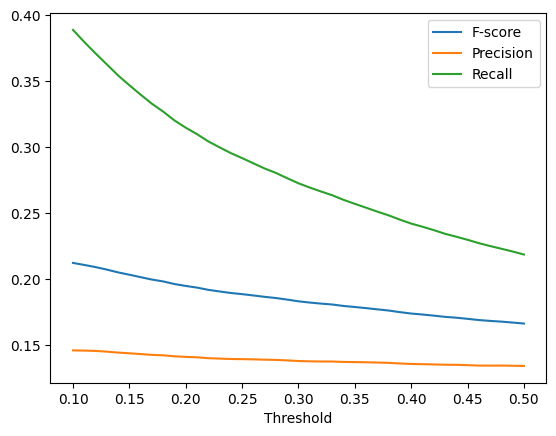

In [13]:
import numpy as np
# import matplotlib.pyplot as plt
import pandas as pd 

# experiment_path = "./experiments/Join_fusion/2024-08-10_17-15-08_03c282e8570e11efaca83cecefb1a652/" 
df = pd.read_csv(experiment_path + 'thresholded_results.csv')

# Get threshold for max F-score
max_fscore_idx = df['F-score'].idxmax()
max_fscore_threshold = df['Threshold'][max_fscore_idx]
max_fscore = df['F-score'][max_fscore_idx]

# Get threshold for max Accuracy
# max_acc_idx = df['Accuracy'].idxmax()
# max_acc_threshold = df['Threshold'][max_acc_idx]
# max_acc = df['Accuracy'][max_acc_idx]

print("Max F-score:", max_fscore, " at threshold:", max_fscore_threshold)
# print("Max accuracy:", max_acc, " at threshold:", max_acc_threshold)

import matplotlib.pyplot as plt
plt.plot(df['Threshold'].values, df['F-score'].values, label='F-score')
plt.plot(df['Threshold'].values, df['Precision'].values, label='Precision')
plt.plot(df['Threshold'].values, df['Recall'].values, label='Recall')
# plt.plot(df['Threshold'].values, df['Accuracy'].values, label='Accuracy')
plt.xlabel('Threshold')
plt.legend()
plt.show()

### Evaluating the performance of the model at the threshold that gives the maximum F-score
### best_threshold_file will contain the path to the predictions file which gave best results. So, evaluate the classwise results with this threshold now.

In [14]:
best_thresh_file = threshold_folder_path + "/predictions_threshold_{}.txt".format(max_fscore_threshold)
estimated_list = []

with open(best_thresh_file, 'r') as file:
    lines = file.readlines()
    lines = lines[1:]

for line in lines:
    out = line.strip().split('\t')

    filename = out[0]
    onset = float(out[1])
    offset = float(out[2])
    event_label = out[3]

    estimated_entry = {
                            'event_label': event_label,
                            'event_onset': onset,
                            'event_offset': offset,
                            'file': filename
                         }
    estimated_list.append(estimated_entry)

In [15]:
reference_event_list = dcase_util.containers.MetaDataContainer(reference_list)
estimated_event_list = dcase_util.containers.MetaDataContainer(estimated_list)

# segment based metrics, change segment length by modifying time_resolution(in sec)
segment_based_metrics = sed_eval.sound_event.SegmentBasedMetrics(
    event_label_list=reference_event_list.unique_event_labels,
    time_resolution=1.0
)

for filename in tqdm(reference_event_list.unique_files):
    
    reference_event_list_for_current_file = reference_event_list.filter(filename=filename)
    estimated_event_list_for_current_file = estimated_event_list.filter(filename=filename)

    segment_based_metrics.evaluate(
        reference_event_list=reference_event_list_for_current_file,
        estimated_event_list=estimated_event_list_for_current_file
    )

# print report
print(segment_based_metrics)

100%|██████████| 2000/2000 [01:21<00:00, 24.39it/s]

Segment based metrics
  Evaluated length                  : 36524.85 sec
  Evaluated files                   : 2000 
  Segment length                    : 1.00 sec

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 21.23 %
    Precision                       : 14.60 %
    Recall                          : 38.89 %
  Error rate
    Error rate (ER)                 : 2.68 
    Substitution rate               : 0.21 
    Deletion rate                   : 0.40 
    Insertion rate                  : 2.07 
  Accuracy
    Sensitivity                     : 38.89 %
    Specificity                     : 82.96 %
    Balanced accuracy               : 60.92 %
    Accuracy                        : 79.88 %

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 20.84 %
    Precision                       : 14.35 %
    Recall                          : 38.37 %
  Error rate
    Error rate (ER)                 : 2.88 
    Deletion r